In [4]:
%%capture
pip install investpy

In [5]:
%%capture
pip install arch

In [8]:
import investpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statistics
import os
import glob
from google.colab import output
from google.colab import files

from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from keras import Model

In [9]:
cryptos=investpy.get_cryptos()
cryptos

,name,symbol,currency
0,Bitcoin,BTC,USD
1,Ethereum,ETH,USD
2,Binance Coin,BNB,USD
3,Tether,USDT,USD
4,Cardano,ADA,USD
...,...,...,...
1032,United Bitcoin,UBTC,USD
1033,CryptoWorldX Token,CWXT,USD
1034,Cryptoindex.com 100,CIX100,USD
1035,Digital Bullion Gold,DBG,USD


In [10]:
#### See one example:
data = investpy.get_crypto_historical_data(crypto='Bitcoin', from_date='01/01/2018', to_date='30/12/2021')
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2018-01-01,13850.5,13921.5,12877.7,13444.9,78425,USD
2018-01-02,13444.9,15306.1,12934.2,14754.1,137732,USD
2018-01-03,14754.1,15435.0,14579.7,15156.6,106543,USD
2018-01-04,15156.5,15408.7,14244.7,15180.1,110969,USD
2018-01-05,15180.1,17126.9,14832.4,16954.8,141960,USD
...,...,...,...,...,...,...
2021-12-26,50404.0,51247.0,49527.0,50779.9,32343,USD
2021-12-27,50783.6,52016.3,50459.0,50678.2,43902,USD
2021-12-28,50703.4,50703.8,47345.7,47545.2,74391,USD


In [37]:
#### two folders on Google Drive to save or load data 
data_path = "/content/drive/My Drive/Github/finaldata/"
tuning_path = "/content/drive/My Drive/Github/Tuning_Results/"

In [12]:
#### 5 most traded cryptocurrencies that have at least 4 years of data
crypto_list = ["Bitcoin", "Ethereum", "XRP", "Cardano", "Binance Coin"]

In [26]:
#### Get data from investing.com 
all_data = {}
for crypto in crypto_list:
  all_data[crypto] = investpy.get_crypto_historical_data(crypto=crypto, from_date='01/01/2018', to_date='30/12/2021')
  data['Date']=data.index
  from_date = data['Date'][0].date()
  to_date = data['Date'][len(data)-1].date()
  all_data[crypto].drop(['Open','High','Low','Volume','Currency'], axis=1, inplace=True)      ## drop unnecessary columns
   ### upload data to your drive
  os.chdir(data_path)
  all_data[crypto].to_csv(crypto+'.csv')

Once the data was stored on the respective Google Drive folder via running the above code, there is no need to run that cell anymore and the following code can be used to load the saved data into the Colab.

In [13]:
#### Import data from google drive to google colab
os.chdir(data_path)
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(all_filenames)
## read the csv files into a dictionary
all_data = {}
for f in all_filenames:
  crtpto = f.replace('.csv', '')
  all_data[crtpto] = pd.read_csv(f)

## see an example:
all_data['Bitcoin']

['Bitcoin.csv', 'Ethereum.csv', 'XRP.csv', 'Cardano.csv', 'Binance Coin.csv']


,Date,Close
0,2018-01-01,13444.9
1,2018-01-02,14754.1
2,2018-01-03,15156.6
3,2018-01-04,15180.1
4,2018-01-05,16954.8
...,...,...
1455,2021-12-26,50779.9
1456,2021-12-27,50678.2
1457,2021-12-28,47545.2
1458,2021-12-29,46461.7


To evaluate the models’ performances, we need to compare predicted values of volatility with its actual values, however, volatility is an unobservable variable, and it is not measurable. Since standard deviation indicates how much a cryptocurrency has varied during a certain period, we can use this feature as a proxy for volatility. Therefore, historical volatility at day t is calculated as standard deviations of the returns’ values using the following equation where:


*   r_i: the return value of cryptocurrency on day i
*   (r_t)_: the average return value of cryptocurrency during past T trading days
*   T=30 (approximately one month of transactions) 


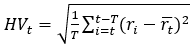

In [14]:
for crypto in crypto_list: 
  ### calculate log-returns:  log_ret = log⁡(Close_t )-log⁡(Close_(t-1) )	
  log_ret = np.log(all_data[crypto].Close) - np.log(all_data[crypto].Close.shift(1)) 
  all_data[crypto]['returns'] = log_ret
  ### calculate Historical volatilities
  all_data[crypto]['HV'] = np.nan
  for i in range(len(all_data[crypto]))[30:]:
    sample = []
    for j in range(30):
      sample.append(all_data[crypto].returns[i-j])
    all_data[crypto]['HV'].iloc[i]= statistics.stdev(sample)

  all_data[crypto]['returns'].replace(np.inf, 0.000001, inplace=True)
  all_data[crypto]['returns'].replace(-np.inf, 0.000001, inplace=True)
  all_data[crypto].dropna(inplace=True)                                   ## the first 30 values of HV will be nan values as a result of using HV equation and they should be dropped
  all_data[crypto].drop(['Close','returns'], axis=1, inplace=True)        ## drop unnecessary columns
 

## See an example:
all_data['Bitcoin']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,HV
30,2018-01-31,0.065164
31,2018-02-01,0.064834
32,2018-02-02,0.064385
33,2018-02-03,0.065113
34,2018-02-04,0.063007
...,...,...
1455,2021-12-26,0.032850
1456,2021-12-27,0.032611
1457,2021-12-28,0.033177
1458,2021-12-29,0.033191


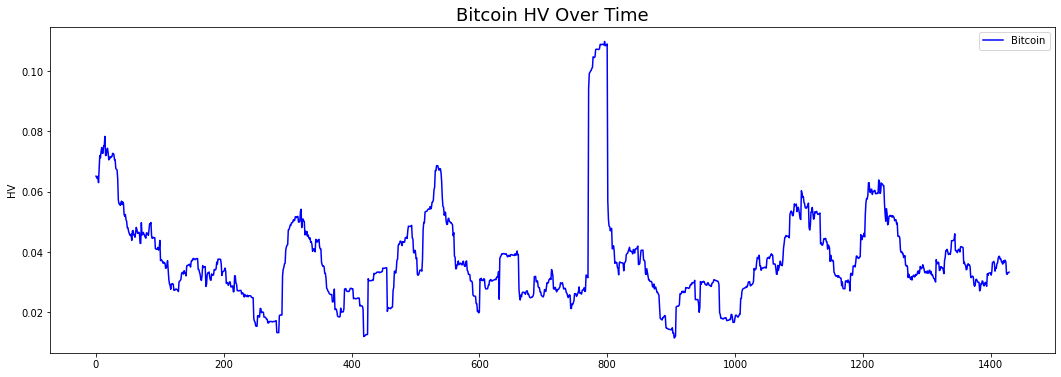

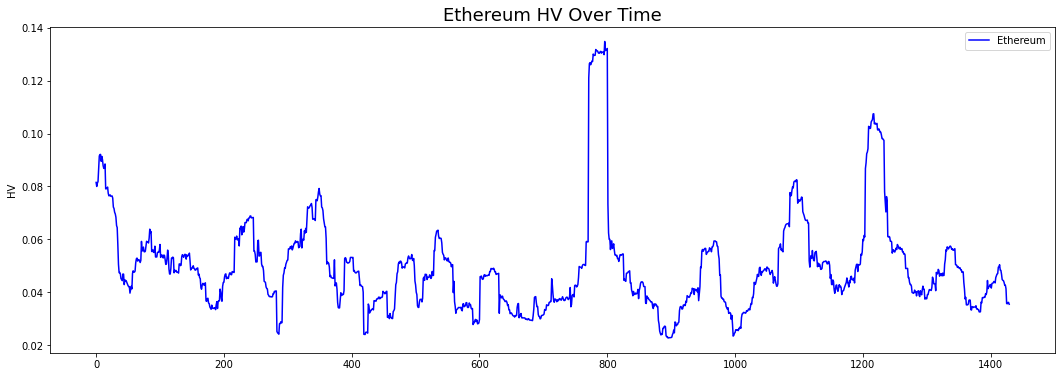

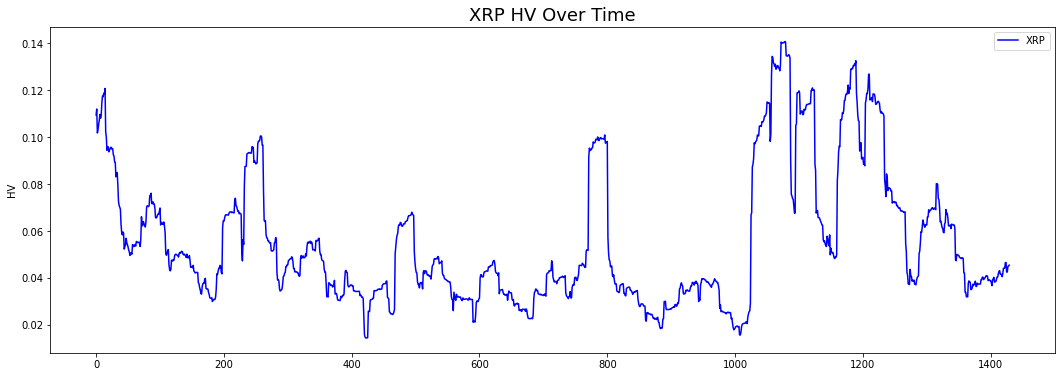

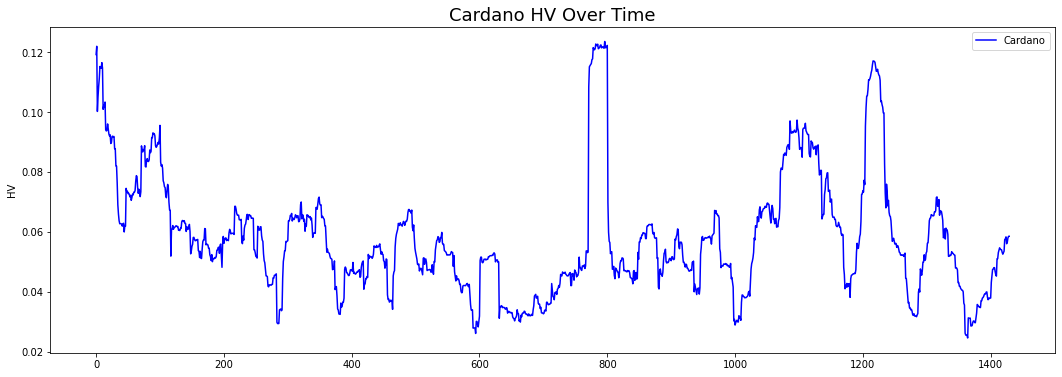

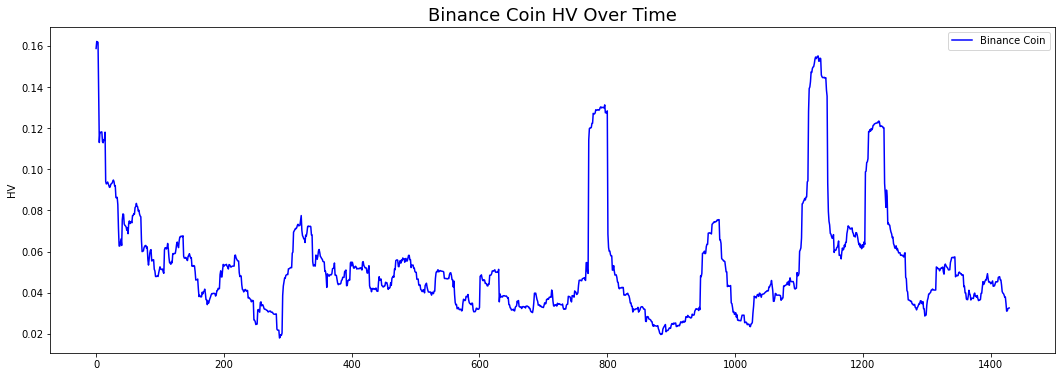

In [15]:
#### line plots of Historical Volatility for each cryptocurrency
for key, value in all_data.items():
  data = value
  crypto = key.replace('.csv', '')
  ## line plots
  plt.figure(figsize=(18,6))
  plt.plot(data['HV'].values, color = 'blue', label = crypto)
  plt.title(label = crypto + ' HV Over Time', fontsize=18)
  plt.ylabel('HV')
  plt.legend()
  plt.show()

Each dataset will be divided into two parts: the first 80% as the training sample, and the remaining 20% as the testing sample. Moreover, for the purpose of hyper-parameter tuning of deep learning models, the last 20% of the training sample will be used as the validation sample. 

In [16]:
#### data split parameters
example_data = all_data['Bitcoin']
train_valid_size = int(0.8*len(example_data))
valid_size = int(0.2*(0.8*len(example_data)))
train_size = train_valid_size - valid_size 
test_size = len(example_data) - int(0.8*len(example_data))

print("size of the train_valid set: ", train_valid_size)
print("size of the train set: ", train_size)
print("size of the validation set: ", valid_size)
print("size of the test set: ", test_size)
print('total: ', train_size + valid_size + test_size)

size of the train_valid set:  1144
size of the train set:  916
size of the validation set:  228
size of the test set:  286
total:  1430


The `prepare_input()` function prepares training, validation, and testing samples for each cryptocurrency dataset. 
`Feature` specifies the input data and `h` defines how many lags of input data should be used in training set construction. In other words, the objective is to train the models such that h lagged values of HV_t are fed as an input vector to predict HV_t. 
In this notebook, `Feature = ['HV']` and `h = 6` (approximately one week of transactions) will be used. 
*   For the purpose of hyper-parameter tuning on validation set, use the function as `prepare_input(data, train_size, valid_size, feature, h)`
*   For the purpose of evaluating the models on test set, use the function as `prepare_input(data, train_valid_size, test_size, feature, h)`





In [23]:
def prepare_input(data, train_size, valid_size, feature, h):
  '''
  This function prepares training, validation, and testing samples for each cryptocurrency dataset. 
  '''
  train_set = data[feature][:train_size].values 
  valid_set = data[feature][train_size:train_size+valid_size].values 
  ## Feature Scaling
  sc = MinMaxScaler(feature_range = (0, 1))
  train_set_scaled = sc.fit_transform(train_set)
  ## Creating a data structure with h time-steps and 1 output
  X_train = []
  y_train = []
  for i in range(h, train_size):
    X_train.append(train_set_scaled[i-h:i])                         ## X1:(HV0,HV1,HV2,HV3,HV4,HV5) ==> y1:HV6
    y_train.append(train_set_scaled[i, 0])                          ## 1 --> to consider only 'HV' as the y_train
  X_train, y_train = np.array(X_train), np.array(y_train)           ## X_train.shape = (train_size-h, h, number of features)
  ## preparing the validation set for making predictions
  dataset_train = data[feature][:train_size]    
  y_valid = data[feature][train_size:train_size+valid_size]
  dataset_train_valid = pd.concat((dataset_train, y_valid), axis = 0)
  valid_h = dataset_train_valid[len(dataset_train_valid)-len(y_valid)-h:].values  ## valid_h.shape = (valid_size + h , number of features)
  valid_h = sc.transform(valid_h)
  X_valid = []
  for i in range(h, valid_h.shape[0]):
    X_valid.append(valid_h[i-h:i])
  X_valid = np.array(X_valid)      ## X_valid.shape = (valid_size , h , number of features)
  return X_train, y_train, X_valid, y_valid, train_set_scaled

In [33]:
## Create single model (functional API)
'''
This function will be used to create one of the following models:
RNN, LSTM, and Bidirectional LSTM
'''
def create_single_model(model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape, activation):
    input = Input(shape=input_shape)
    if model_name == "RNN":
      if layer_number == 1:
        x = SimpleRNN(hidden_units, return_sequences=False, activation=activation)(input)
      elif layer_number == 2:
        x = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(input)
        x = SimpleRNN(hidden_units, return_sequences=False, activation=activation)(x)
      else:
        x = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(input)
        x = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
        x = SimpleRNN(hidden_units, return_sequences=False, activation=activation)(x)
    elif model_name == "LSTM":
      if layer_number == 1:
        x = LSTM(hidden_units, return_sequences=False, activation=activation)(input)
      elif layer_number == 2:
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(input)
        x = LSTM(hidden_units, return_sequences=False, activation=activation)(x)
      else:
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(input)
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
        x = LSTM(hidden_units, return_sequences=False, activation=activation)(x)
    else:
      if layer_number == 1:
        x = Bidirectional(LSTM(hidden_units, return_sequences=False, activation=activation))(input)
      elif layer_number == 2:
        x = Bidirectional(LSTM(hidden_units, return_sequences=True, activation=activation))(input)
        x = Bidirectional(LSTM(hidden_units, return_sequences=False, activation=activation))(x)
      else:
        x = Bidirectional(LSTM(hidden_units, return_sequences=True, activation=activation))(input)
        x = Bidirectional(LSTM(hidden_units, return_sequences=True, activation=activation))(x)
        x = Bidirectional(LSTM(hidden_units, return_sequences=False, activation=activation))(x)

    if Dropout_layer == True:
      z = Dense(dense_units, activation = activation)(x)
      z = Dropout(0.2)(z)
    else:
      z = Dense(dense_units, activation = activation)(x)

    z = Dense(1, activation='linear')(z)
    model = Model(inputs=input, outputs=z)  
    return model 

To evaluate each model’s performance, we will use the Root Mean Squared Error (RMSE) measure where: 


*   HV_i: Historical Volatility at day i 
*   HV^_i: Predicted Historical Volatility at day i
*   n: the number of predictions which is equal to the size of test set (in case of testing) and the size of validation set (in case of validating or tuning)

The lower is RMSE the better is the accuracy of predictions.

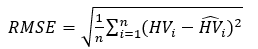

In [34]:
def model_evaluation(Tuning, model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape, activation, loss, optimizer, epochs, batch_size):
  '''
  This function can be used for both tuning and testing purposes: 
   "Tuning" = True --> for tuning on validation set
   "Tuning" = False --> for testing on test set
  '''
  model = create_single_model(model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape, activation)
  model.compile(loss=loss, optimizer=optimizer)
  model_fit = model.fit(x=inputs[0], y=inputs[1], epochs = epochs, batch_size = batch_size, verbose=0)
  predicted_HV = model.predict(inputs[2]) 

  sc2 = MinMaxScaler(feature_range = (0, 1))
  if Tuning==True:
    just_to_fit = data.iloc[train_size:train_valid_size, 1].values                      ## for inverting the predicted values to their original scale
    just_to_fit = just_to_fit.reshape(valid_size, 1)
  else:
    just_to_fit = data.iloc[train_valid_size:train_valid_size+test_size, 1].values      ## for inverting the predicted values to their original scale
    just_to_fit = just_to_fit.reshape(test_size,1)

  just_to_inverse = sc2.fit_transform(just_to_fit)
  predicted_HV = sc2.inverse_transform(predicted_HV)
  predicted_HV = predicted_HV.reshape(-1)
  RMSE = np.sqrt(mean_squared_error(inputs[3]['HV'].values, predicted_HV))
  return RMSE, predicted_HV



In order to find an approximate value for the `epochs`, some trial and error was done in the following code, and training for at most 10 epochs was found to be enough. However, a more exact value for this hyper-parameter can be found via hyper-parameter tuning.  

Epoch 1/10
36/36 [==============================] - 2s 10ms/step - loss: 0.0281
Epoch 2/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 3/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 4/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 5/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 6/10
36/36 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 7/10
36/36 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 8/10
36/36 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 9/10
36/36 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 10/10
36/36 [==============================] - 0s 7ms/step - loss: 0.0019
0.020033481674735294


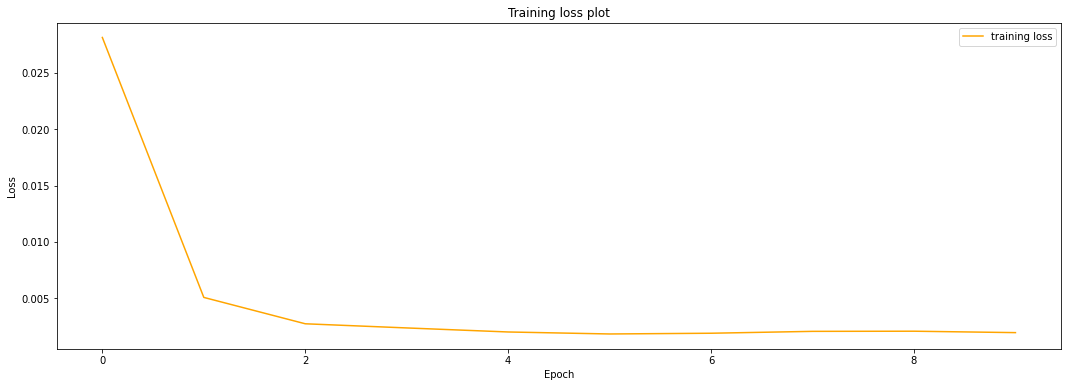

In [35]:
example_data = all_data['Bitcoin']
inputs = prepare_input(example_data, train_valid_size, test_size, ['HV'], 6)
model = create_single_model('RNN', 1, 50, 64, True, (6, 1), 'tanh')
model.compile(loss='mse', optimizer='adam')
model_fit = model.fit(x=inputs[0], y=inputs[1], epochs = 10, batch_size = 32, verbose=1)        ## after some trial and error,  training for at most 10 epochs was found to be enough 
## Plot losses
plt.figure(figsize=(18,6))
plt.title('Training loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(model_fit.history['loss'], color = 'orange', label = 'training loss')
plt.legend()

predicted_HV = model.predict(inputs[2]) 

## for inverting the predicted values to their original scale
sc2 = MinMaxScaler(feature_range = (0, 1))
just_to_fit = data.iloc[train_valid_size:train_valid_size+test_size, 1].values
just_to_fit = just_to_fit.reshape(test_size,1)
just_to_inverse = sc2.fit_transform(just_to_fit)
predicted_HV = sc2.inverse_transform(predicted_HV)

predicted_HV = predicted_HV.reshape(-1)
RMSE = np.sqrt(mean_squared_error(inputs[3]['HV'].values, predicted_HV))
print(RMSE)

# Experiments

The most important hyper-parameters will be tuned using grid search method on the validation set. Consequently, the models’ structures vary from one cryptocurrency to another as each model yields a specific set of optimal hyper-parameters for each cryptocurrency. The results of tuning for each crypto-model combination will be saved as a CSV file on Google Drive folder. 

In [38]:
### Hyper-parameter tuning

layer_numbers = [1, 2, 3]
hidden_units_set = [50, 100]
dense_units_set = [64, 128]
activations = ['tanh', 'relu']                
batch_sizes = [16, 32] 
optimizer = 'adam'                                       
loss = 'mean_squared_error'
epochs = 10

h = 6                  ## approximately one week of transactions
feature = ['HV']       ## historical volatility as a proxy for the volatility
model_names = ['RNN', 'LSTM', 'BiLSTM']
os.chdir(tuning_path)  ## A folder on Google Drive for saving the results of hyper-parameter tuning

for key, value in all_data.items():
  data = value
  crypto = key
  inputs = prepare_input(data, train_size, valid_size, feature, h) 
  input_shape=(inputs[0].shape[1], inputs[0].shape[2])

  for model_name in model_names:
    tun_results = []
    for layer_number in layer_numbers:
      for hidden_units in hidden_units_set:
        for dense_units in dense_units_set:
          for activation in activations:
            for batch_size in batch_sizes:
              RMSE_tun = model_evaluation(True, model_name, layer_number, hidden_units, dense_units, True, input_shape, activation, loss, optimizer, epochs, batch_size)[0]     
              result = [crypto, model_name, layer_number, hidden_units, dense_units, activation, batch_size, RMSE_tun]
              tun_results.append(result)
    tun_results_df = pd.DataFrame(tun_results, columns = ["crypto", "model_name", "layer_number", "hidden_units", "dense_units", "activation", "batch_size", "RMSE_tun"])
    tun_results_df = tun_results_df.sort_values('RMSE_tun')
    tun_results_df.to_csv(crypto + ' ' + model_name + '.csv')
    print(crypto + ' ' + model_name + ' tuning ' + 'is done')

Bitcoin RNN tuning is done
Bitcoin LSTM tuning is done
Bitcoin BiLSTM tuning is done
Ethereum RNN tuning is done
Ethereum LSTM tuning is done
Ethereum BiLSTM tuning is done
XRP RNN tuning is done
XRP LSTM tuning is done
XRP BiLSTM tuning is done
Cardano RNN tuning is done
Cardano LSTM tuning is done
Cardano BiLSTM tuning is done
Binance Coin RNN tuning is done
Binance Coin LSTM tuning is done
Binance Coin BiLSTM tuning is done


Since the tuning results were sorted by RMSE values, the first row of each file is related to the optimized parameters. We can load all csv files and use the first row of each file (indicate by` iloc[0]` in the code) as the optimized parameters in our testing section.


In [39]:
os.chdir(tuning_path)
extension = 'csv'
tun_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(tun_filenames)
## read the csv files into a dictionary
tun_data = {}
for t in tun_filenames:
  tun_data[t.replace('.csv', '')] = pd.read_csv(t)


['Bitcoin RNN.csv', 'Bitcoin LSTM.csv', 'Bitcoin BiLSTM.csv', 'Ethereum RNN.csv', 'Ethereum LSTM.csv', 'Ethereum BiLSTM.csv', 'XRP RNN.csv', 'XRP LSTM.csv', 'XRP BiLSTM.csv', 'Cardano RNN.csv', 'Cardano LSTM.csv', 'Cardano BiLSTM.csv', 'Binance Coin RNN.csv', 'Binance Coin LSTM.csv', 'Binance Coin BiLSTM.csv']


In [40]:
for key, value in sorted(tun_data.items()):
  print(key)

Binance Coin BiLSTM
Binance Coin LSTM
Binance Coin RNN
Bitcoin BiLSTM
Bitcoin LSTM
Bitcoin RNN
Cardano BiLSTM
Cardano LSTM
Cardano RNN
Ethereum BiLSTM
Ethereum LSTM
Ethereum RNN
XRP BiLSTM
XRP LSTM
XRP RNN


In [41]:
### Testing the models on test sets

seed(1)
tf.random.set_seed(1)

RMSE_results = []
Predicted_values = []
for key, value in sorted(tun_data.items()):
  crypto = tun_data[key].iloc[0]['crypto']
  model_name = tun_data[key].iloc[0]['model_name']
  data = all_data[crypto]
  inputs = prepare_input(data, train_valid_size, test_size, feature, h) 
  input_shape = (inputs[0].shape[1], inputs[0].shape[2])
  evaluation_result = model_evaluation(False, model_name, tun_data[key].iloc[0]['layer_number'], tun_data[key].iloc[0]['hidden_units'], tun_data[key].iloc[0]['dense_units'],
                                      True, input_shape, tun_data[key].iloc[0]['activation'], loss, optimizer, epochs, tun_data[key].iloc[0]['batch_size'])
  RMSE_results.append([crypto, model_name, evaluation_result[0]])
  
  Predicted_values.append(evaluation_result[1])

RMSE_results_df = pd.DataFrame(RMSE_results, columns = ["crypto", "model_name", "RMSE_test"])
RMSE_results_df


,crypto,model_name,RMSE_test
0,Binance Coin,BiLSTM,0.006549
1,Binance Coin,LSTM,0.007096
2,Binance Coin,RNN,0.007496
3,Bitcoin,BiLSTM,0.006173
4,Bitcoin,LSTM,0.006286
5,Bitcoin,RNN,0.005993
6,Cardano,BiLSTM,0.005749
7,Cardano,LSTM,0.008385
8,Cardano,RNN,0.004184
9,Ethereum,BiLSTM,0.006681


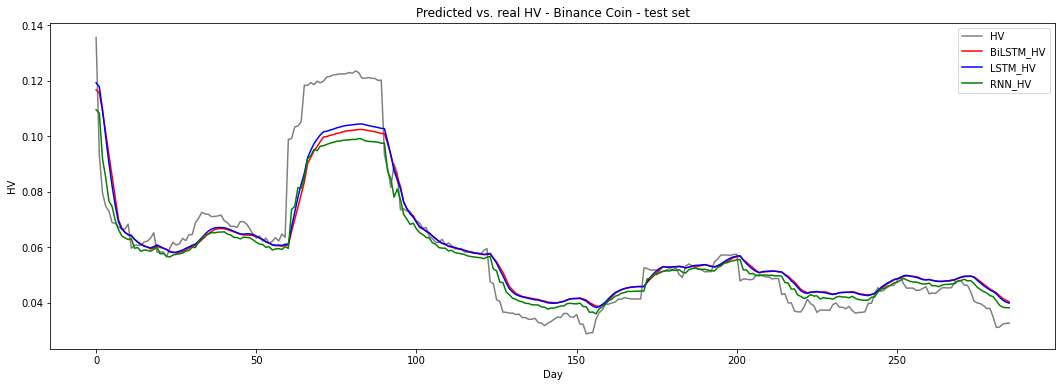

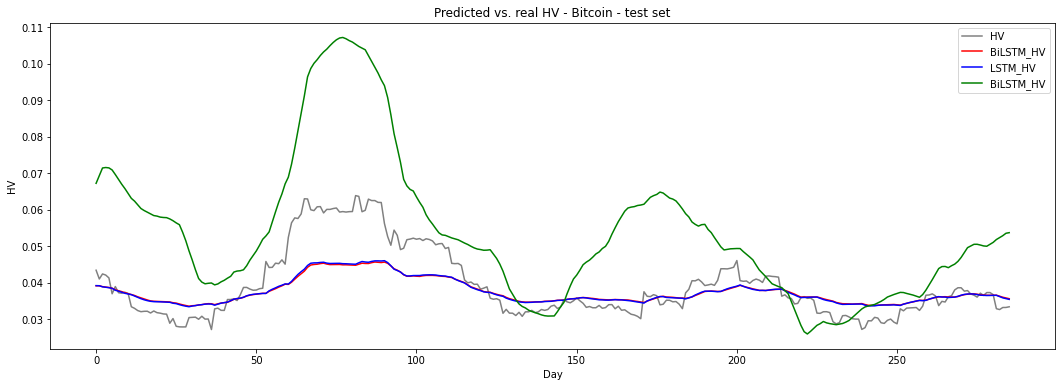

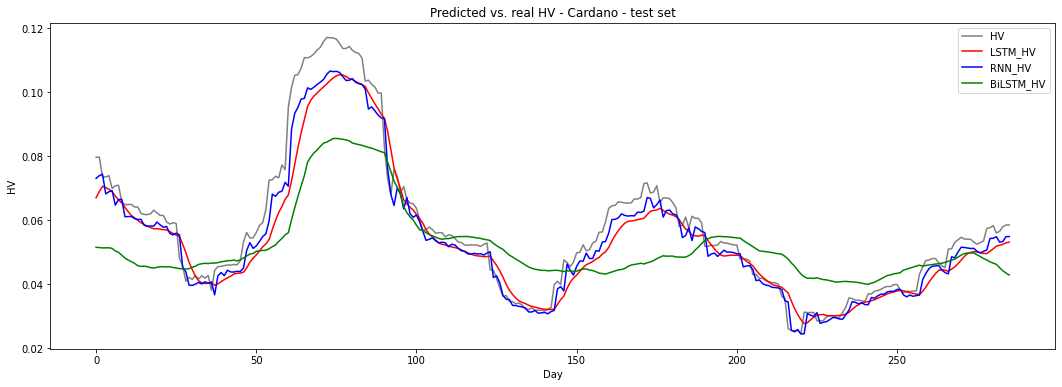

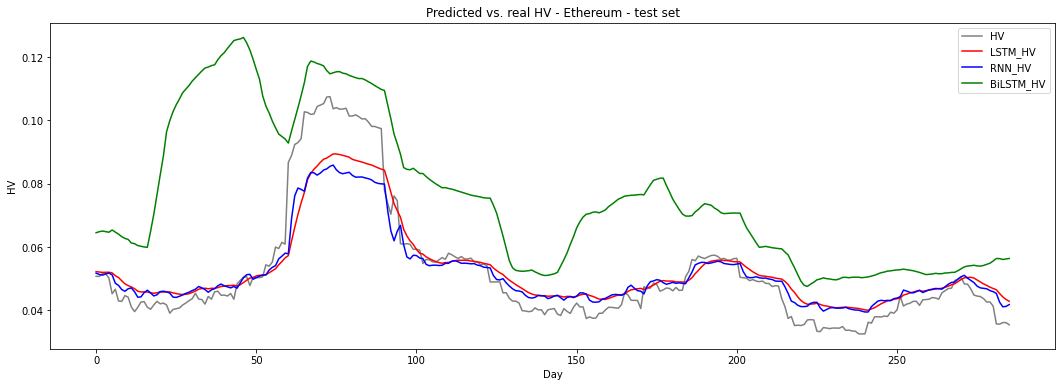

In [255]:
#### Plots of predicted vs. real HV
for i in [0, 3, 6, 9]:
  crypto = RMSE_results_df.iloc[i]['crypto']
  data = all_data[crypto]
  inputs = prepare_input(data, train_valid_size, test_size, feature, h) 
  plt.figure(figsize=(18,6))
  plt.title("Predicted vs. real HV - " + crypto + " - test set")
  plt.plot( inputs[3]['HV'].values, color = 'gray', label = 'HV')
  plt.plot(Predicted_values[i], color = 'red', label = RMSE_results_df.iloc[i]['model_name'] + '_HV')
  plt.plot(Predicted_values[i+1], color = 'blue', label = RMSE_results_df.iloc[i+1]['model_name'] +'_HV')
  plt.plot(Predicted_values[i+2], color = 'green', label = RMSE_results_df.iloc[i+2]['model_name'] +'_HV')

  plt.xlabel('Day')
  plt.ylabel('HV')
  plt.legend()
  plt.show()
